In [26]:
import math
import os
import re
import string
import matplotlib.pyplot as plt
import numpy as np

In [27]:
train_path = "data/train.txt"

In [28]:
def normalize_text(name):
    print("Reading file:",name)
    with open(name,encoding='utf8') as f:
        text = f.read()
        text = text.lower()
        text = re.sub('['+string.punctuation+']', '', text)
        text = re.sub('[0-9]','',text)
    return text

In [29]:
def get_counts(text):
    uni_counts = {}
    bi_counts = {}
    tri_counts = {}
    # n=1
    txt_list = text.split()
    for w in txt_list:
        if w not in uni_counts:
            uni_counts[w] = 1
        else:
            uni_counts[w] += 1
    # n=2
    bi_grams = list(zip(txt_list,txt_list[1:]))
    for g in bi_grams:
        if g not in bi_counts:
            bi_counts[g] = 1
        else:
            bi_counts[g] += 1
    bi_counts = {k: v for k, v in bi_counts.items() if v > 1}
    # n=3
    tri_grams = list(zip(txt_list,txt_list[1:],txt_list[2:]))
    for g in tri_grams:
        if g not in tri_counts:
            tri_counts[g] = 1
        else:
            tri_counts[g] += 1
    tri_counts = {k: v for k, v in tri_counts.items() if v > 1}
    return uni_counts, bi_counts, tri_counts

In [30]:
train_text = normalize_text(train_path)
N = len(train_text.split())
train_1, train_2, train_3 = get_counts(train_text)
V = len(train_1)
#print(train_3)

Reading file: data/train.txt


In [31]:
'''
take the normalized text in string format
n denotes the n-gram vocab to generate
prune : prunes n-grams that occur only once
smooth : applies Laplace/Lidstone smoothing
alpha : alpha value for smoothing
'''
def generate_probs(text,counts,smooth=False,alpha=0.0):
    #vocabs = []
    train_1,train_2, train_3 = counts[0],counts[1],counts[2]
    N_c = len(train_1)
    if not smooth:
        probs_1 = {k:v/N_c for k,v in train_1.items()}
        probs_2 = {k:v/train_1[k[0]] for k,v in train_2.items()}
        probs_3 = {k:v/train_2[k[:-1]] for k,v in train_3.items()}
    else:
        probs_1 = {k:(v+alpha/(N_c+(alpha*V))) for k,v in train_1.items()}
        probs_2 = {k:(v+alpha/(train_1[k[0]]+(alpha*V))) for k,v in train_2.items()}
        probs_3 = {k:(v/(train_2[k[:-1]]+(alpha*V))) for k,v in train_3.items()}
    return probs_1, probs_2, probs_3

### Unsmoothed Probs

In [32]:
probs_1, probs_2, probs_3 = generate_probs(train_text,(train_1,train_2,train_3))

In [33]:
print(len(probs_1))
print(len(probs_2))
print(len(probs_3))

8331
11895
7622


### Smoothed Probs

In [34]:
N = len(train_text)
V = len(set(train_text))
alpha = 0.1

In [35]:
#smoothed_vocabs_uni = generate_vocabs(train_text,1)
#smoothed_vocabs_bi = generate_vocabs(train_text,2,prune=True)
s_probs_1, s_probs_2, s_probs_3 = generate_probs(train_text,(train_1,train_2,train_3),smooth=True,alpha=0.1)

## Compute Perplexity now

In [36]:
test_path = "data/test.txt"

In [37]:
test_text = normalize_text(test_path)
test_text = test_text.replace("“","")
test_text = test_text.replace("”","")
N_t = len(test_text.split())
# test_vocabs_uni = rel_freqs(test_text,1)
# test_vocabs_bi = rel_freqs(test_text,2)
# test_vocabs_tri = rel_freqs(test_text,3)
test_counts_1, test_counts_2, test_counts_3 = get_counts(test_text)
testf_1 = {k:v/N_t for k,v in test_counts_1.items()}
# testf_2 = {k:v/sum(test_counts_2.values()) for k,v in test_counts_2.items()}
# testf_3 = {k:v/sum(test_counts_3.values()) for k,v in test_counts_3.items()}
testf_2 = {k:v/N_t for k,v in test_counts_2.items()}
testf_3 = {k:v/N_t for k,v in test_counts_3.items()}

#print(test_text)

Reading file: data/test.txt


In [38]:
def compute_perplexity_1(test_dist, train_dist):
    #print(len(list(train_dist.keys())[0]))
    #print(len(list(test_dist.keys())[0]))
    #assert len(list(train_dist.keys())[0]) == len(list(test_dist.keys())[0])
    #n = list(train_dist.keys())[0]
    pp = 0
    V_1 = len(train_dist)
    #bi_grams = list(zip(test_text,test_text[1:]))
    uni_grams = test_text.split()
    
    for gram in test_dist.keys():
        if gram in train_dist:
            pp += test_dist[gram] * math.log(train_dist[gram])
            ##pp += math.log(train_dist[gram])
        else:
            #pp += test_dist[gram] * math.log(alpha / (train_text.count(" ".join(gram[:-1])) + alpha*V_t))
            try:
                pp += test_dist[gram] * math.log(alpha / (N + alpha*V_1))
                ##pp += math.log(alpha / (train_2[gram[:-1]] + alpha*V))
                #print("Here")
            except KeyError:
                pp += 0
    print(pp)
    pp = math.exp(-pp)
    return pp

In [39]:
def compute_perplexity_2(test_dist, train_dist, is_interpolated=False):
    #print(len(list(train_dist.keys())[0]))
    #print(len(list(test_dist.keys())[0]))
    assert len(list(train_dist.keys())[0]) == len(list(test_dist.keys())[0])
    n = list(train_dist.keys())[0]
    pp = 0
    V_2 = len(train_dist)
    for gram in test_dist.keys():
        if gram in train_dist:
            
            pp += test_dist[gram] * math.log(train_dist[gram])
            
            ##pp += math.log(train_dist[gram])
        else:
            #pp += test_dist[gram] * math.log(alpha / (train_text.count(" ".join(gram[:-1])) + alpha*V_t))
            try:
                if not is_interpolated:
                    pp += test_dist[gram] * math.log(alpha / (train_1[gram[:-1]] + alpha*V_2))
                else:
                    pp += 0
                ##pp += math.log(alpha / (train_2[gram[:-1]] + alpha*V))
                #print("Here")
            except KeyError:
                pp += 0
    pp = math.exp(-pp)
    return pp

In [40]:
def compute_perplexity_3(test_dist, train_dist, is_interpolated = False):
    #print(len(list(train_dist.keys())[0]))
    #print(len(list(test_dist.keys())[0]))
    assert len(list(train_dist.keys())[0]) == len(list(test_dist.keys())[0])
    n = list(train_dist.keys())[0]
    pp = 0
    V_3 = len(train_dist)
    for gram in test_dist.keys():
        if gram in train_dist:
            pp += test_dist[gram] * math.log(train_dist[gram])
            ##pp += math.log(train_dist[gram])
        else:
            #pp += test_dist[gram] * math.log(alpha / (train_text.count(" ".join(gram[:-1])) + alpha*V_t))
            try:
                if not is_interpolated:
                    pp += test_dist[gram] * math.log(alpha / (train_2[gram[:-1]] + alpha*V_3))
                else:
                    pp += 0
                ##pp += math.log(alpha / (train_2[gram[:-1]] + alpha*V))
                #print("Here")
            except KeyError:
                pp += 0
    print(pp)
    pp = math.exp(-pp)
    return pp

In [41]:
#print(compute_perplexity(test_vocabs_tri,smoothed_vocabs_tri))
print(compute_perplexity_1(testf_1,s_probs_1))
print(compute_perplexity_3(testf_3,s_probs_3))

2.34589157995262
0.0957617847704256
-0.6474186305543224
1.9106024870306921


In [42]:
probs_I_3 = {k:v for k,v in probs_3.items()}
for k in probs_3:
    probs_I_3[k] = ((1/3) * probs_1[k[-1]]) + ((1/3) * probs_2[k[1:]]) + ((1/3) * probs_3[k])


In [43]:
print(compute_perplexity_3(testf_3,probs_I_3, is_interpolated=True))

-0.07142520869179807
1.0740378190037534


In [44]:
sorted_3_s = sorted( ((v,k) for k,v in s_probs_3.items()), reverse=True)
sorted_3_I = sorted( ((v,k) for k,v in probs_I_3.items()), reverse=True)
print("Smoothed:",sorted_3_s[:10])
print("\nInterpolated:",sorted_3_I[:10])

Smoothed: [(0.8653846153846154, ('lord', 'st', 'simon')), (0.8455882352941176, ('what', 'do', 'you')), (0.8189655172413793, ('as', 'far', 'as')), (0.8024691358024691, ('mr', 'hosmer', 'angel')), (0.7692307692307693, ('one', 'or', 'two')), (0.7575757575757576, ('the', 'copper', 'beeches')), (0.7575757575757576, ('in', 'spite', 'of')), (0.7575757575757576, ('beg', 'that', 'you')), (0.7377049180327869, ('mr', 'neville', 'st')), (0.7359307359307359, ('i', 'do', 'not'))]

Interpolated: [(0.8907694154363222, ('to', 'protect', 'the')), (0.8907694154363222, ('suddenly', 'realising', 'the')), (0.8907694154363222, ('could', 'distinguish', 'the')), (0.8352138598807666, ('up', 'onto', 'the')), (0.8074360821029888, ('i', 'rang', 'the')), (0.7955313201982268, ('from', 'amid', 'the')), (0.7867002760773016, ('were', 'twins', 'and')), (0.7867002760773016, ('an', 'orphan', 'and')), (0.7867002760773016, ('a', 'widower', 'and')), (0.7860075106744173, ('up', 'among', 'the'))]


### Cross Validation

In [45]:
kfold_path = 'data/kfold.txt'

In [46]:
kf_text = normalize_text(kfold_path)
N_kf = len(kf_text.split())
print (N_kf)

Reading file: data/kfold.txt
26395


In [47]:
K = 5
lmb = (np.arange(0.0,1.01,0.01))

In [48]:
def kfold(text, lmb1, k=5):
    lmb2 = 1 - lmb1
    N_k = len(text)
    ind = N_k // k
    pp_vals = []
    for i in range(K):
        val_data = text[i*ind:(i+1)*ind]
        # Combine rest of data to training data
        train_data = text[:i*ind] + text[(i+1)*ind:]
        uni_counts, bi_counts, tri_counts = get_counts(train_data)
        uni_probs, bi_probs, _ = generate_probs(train_text,(uni_counts,bi_counts,tri_counts))
        N_val = len(val_data)
        # Generate P_I_2 (Interpolated Bi-gram)
        probs_I_2 = {k:v for k,v in bi_probs.items()}
        for m in bi_probs:
            probs_I_2[m] = (lmb1 * uni_probs[m[-1]]) + (lmb2 * bi_probs[m])
        uni_val_counts, bi_val_counts, _ = get_counts(val_data)
        #rf_val_uni = {k:v/N_val for k,v in uni_val_counts.items()}
        rf_val_bi = {k:v/N_val for k,v in bi_val_counts.items()}
        
        pp_vals.append(compute_perplexity_2(rf_val_bi,probs_I_2,is_interpolated=True))
    mean = np.mean(pp_vals)
    return mean

In [49]:
# Call kfold for varying lmb1
pp = []
min_lmb = None
min_pp = 1000000
for lmb1 in lmb:
    pp.append(kfold(kf_text,lmb1))
    if pp[-1] < min_pp:
        min_pp = pp[-1]
        min_lmb = lmb1
print("Minimum PP:",min_pp,"Lambda1:",min_lmb,"Lambda2:",(1-min_lmb))

Minimum PP: 1.15623863731 Lambda1: 0.49 Lambda2: 0.51


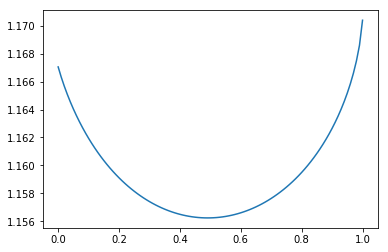

In [50]:
plt.plot(lmb,pp);
plt.show()